In [21]:
%matplotlib notebook

import corex as cx
import vis_corex as vcx
from gensim import models
import numpy as np
from time import time
import re
from itertools import groupby
import matplotlib.pyplot as plt

# Load embeddings using `gensim`

In [2]:
embeddings_gensim = models.KeyedVectors.load_word2vec_format(fname="data/vectors_Goldberg_sample.txt", binary=False)
# capture indexes
word_idxs = list(map(lambda x: x[0], embeddings_gensim.vocab.items()))
word_idxs[:5]

['the', '.', ',', 'is', 'and']

# Load embeddings into `numpy` matrix

In [3]:
emb_matrix = embeddings_gensim.syn0
emb_matrix.shape

(4999, 300)

# Build single layer `CoRex` representation

## hyperparameters

In [4]:
num_hidden = 2      # number of Y_s; number of clusters?  m?
cluster_dim = 10      # dimension of each hidden; k?
max_samples = emb_matrix.shape[0]
max_iter=12          # previous runs show this is sufficient
random_seed = 1978

In [5]:
corex_layer_1 = cx.Corex(
    n_hidden=num_hidden,            
    dim_hidden=cluster_dim,            
    marginal_description='gaussian',   # for continuous data
    max_iter=max_iter,
    max_samples=max_samples,
    seed=random_seed,
    verbose=True,
    ram=2
)

corex, rep size: 2 10
Marginal description:  gaussian


## fit

In [6]:
t0 = time()
ys_layer_1 = corex_layer_1.fit_transform(emb_matrix)
print("time to compute: {} seconds".format(time() - t0))

[ 0.052  0.055]
[ 1.924  2.712]
[ 10.095   8.8  ]
[ 15.134  10.41 ]
[ 16.392  10.618]
[ 16.995  10.575]
[ 17.417  10.58 ]
[ 17.672  10.415]
[ 17.961  10.048]
[ 18.184   9.683]
[ 18.274   9.621]
[ 18.401   9.536]
Overall tc: 27.9363591396
Best tc: 27.9363591396
time to compute: 144.49451661109924 seconds


## labels

`.labels` is the size of your data.  And `.labels[i]` gives you the values for each $Y_j$ for the $i^{th}$ datapoint

In [7]:
corex_layer_1.labels[0]

array([3, 5])

So....in theory, two words with a high `cosine similarity` in embedding space, should also have similar `label vectors`.

In [8]:
embeddings_gensim.most_similar(["his"])

[('their', 0.8471860885620117),
 ('its', 0.7965162396430969),
 ('my', 0.7934165000915527),
 ('your', 0.7914167642593384),
 ('our', 0.7593696713447571),
 ('whose', 0.738511323928833),
 ('her', 0.6965184211730957),
 ('the', 0.4893943667411804),
 ('``', 0.4586181342601776),
 ("'ll", 0.4517585039138794)]

In [9]:
index_of_his = word_idxs.index('his')
index_of_their = word_idxs.index('their')

corex_layer_1.labels[index_of_his], corex_layer_1.labels[index_of_their]

(array([3, 8]), array([3, 8]))

And presumably two `dissimilar` words in embedding space should have dissimilar `label vectors`.

In [10]:
embeddings_gensim.most_similar(["his"], topn=len(word_idxs))[-3:]

[('eleven', 0.07403583079576492),
 ('announced', 0.06627192348241806),
 ('premiere', 0.05658423900604248)]

In [11]:
index_of_premiere = word_idxs.index('premiere')

corex_layer_1.labels[index_of_his], corex_layer_1.labels[index_of_premiere]

(array([3, 8]), array([1, 0]))

In [38]:
coordinates = {}
for idx, label in enumerate(corex_layer_1.labels):
    coord = tuple(label)
    if coord in coordinates:
        coordinates[coord].append(word_idxs[idx])
    else:
        coordinates[coord] = [word_idxs[idx]]

<IPython.core.display.Javascript object>


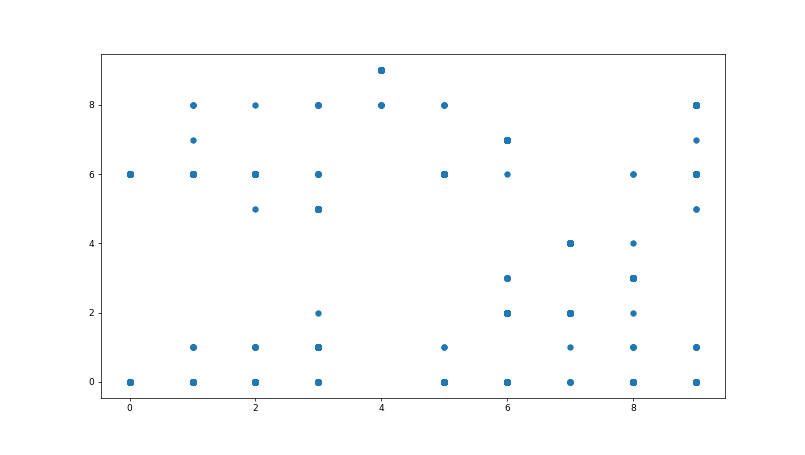

In [49]:
xs, ys = zip(*corex_layer_1.labels)
plt.scatter(
    xs, 
    ys
)
plt.show()

In [46]:
for coordinate_pair, words_ in sorted(coordinates.items(), key=lambda x: (x[0], x[1])):
    print("The coordinate pair {} contains the following {} words:\n{}".format(
        coordinate_pair, len(words_), ",".join(words_)
        )
    )
    print("\n")

The coordinate pair (0, 0) contains the following 77 words:
works,features,points,changes,forms,edits,links,claims,places,references,tracks,attacks,plans,stars,matches,attempts,hits,acts,lists,reports,dates,concerns,notes,reviews,wars,singles,votes,lands,heads,races,objects,blocks,processes,releases,ages,tests,costs,matters,experiences,marks,steps,ranks,borders,archives,benefits,credits,battles,talks,admins,ranges,rounds,ties,demands,broadcasts,addresses,scores,challenges,answers,influences,interviews,spots,disputes,counts,targets,conflicts,honors,protests,grades,waves,tags,ruins,grants,trips,lectures,samples,quotes,crops


The coordinate pair (0, 6) contains the following 498 words:
years,people,two,members,articles,times,games,sources,species,men,those,students,children,days,areas,forces,women,schools,services,events,records,books,groups,songs,teams,players,issues,systems,awards,countries,parts,others,pages,films,studies,editors,rights,names,units,problems,characters,lines,companies,

## tcs

`.tcs` provides the `total correlation` captured by each $Y_j$, and are sorted from greatest to least.

In [12]:
corex_layer_1.tcs

array([ 18.401,   9.536])

So in this case, $Y_0$ captures the most `total correlation`.

## clusters

This will identify which cluster each `dimension` of the word embedding should belong to.  See this example:

```
X = np.array([[0,0,0,0,0], # A matrix with rows as samples and columns as variables.
              [0,0,0,1,1],
              [1,1,1,0,0],
              [1,1,1,1,1]], dtype=int)

layer1 = ce.Corex(n_hidden=2, dim_hidden=2, marginal_description='discrete', smooth_marginals=False)  

layer1.fit(X)  # Fit on data. 

layer1.clusters  # Each variable/column is associated with one Y_j
# array([0, 0, 0, 1, 1])
```

You can see that the first three `dimension`s belong together (in cluster `0`) and the last two together.

In [13]:
clusters = corex_layer_1.clusters
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

This generates a clustering of each `dimension` of the word embeddings.  Not sure what meaning this may carry...if any.

In [14]:
clusters = corex_layer_1.clusters
clusters_grouped = groupby(enumerate(clusters), lambda x: x[1])
clusters_dict = {}
for idx, group in clusters_grouped:
    just_dims = list(map(lambda x: x[0], group))
    if idx in clusters_dict:
        clusters_dict[idx].extend(just_dims)
    else:
        clusters_dict[idx] = just_dims
for c, dims in clusters_dict.items():
    print("cluster {} has {} dims".format(c, len(dims)))

cluster 0 has 258 dims
cluster 1 has 42 dims


## visualize

Runs code to generate a bunch of visualizations, which will end up in the directory called `embedding_viz`.

In [15]:
vcx.vis_rep(
    corex=corex_layer_1, 
    data=emb_matrix,
    row_label=word_idxs,
    column_label=None,
    prefix="embedding_viz_2_dim",
    topk=num_hidden
)

Groups in sorted_groups.txt
Pairwise plots among high TC variables in "relationships"
error, not able to visualize with k > 3


UnboundLocalError: local variable 'out' referenced before assignment

## groups

In [16]:
path_to_groups = "embedding_viz_2_dim/text_files/groups_no_overlaps.txt"

In [17]:
group_regex = r'Group num: ([0-9]+), TC.*'
groups = {}
groups_list = []
with open(path_to_groups, "r") as f:
    for line in f:
        if line.startswith("Group num"):
            group_number = re.match(group_regex, line)[1]
            if groups_list:
                groups[int(group_number) - 1] = groups_list
            groups_list = []
        else:
            dim, val = line.rstrip().split(",")
            groups_list.append((dim, val))
groups[int(group_number)] = groups_list

In [18]:
for g, dims in groups.items():
    print("There are {} dims in group {} with a total TCS of {}:\n{}".format(
        len(dims), g, corex_layer_1.tcs[g], ",".join(list(map(lambda x: x[0], dims)))
        )
    )
    print("----")

There are 258 dims in group 0 with a total TCS of 18.40052605381503:
35,296,78,73,184,280,84,197,143,213,225,0,191,48,265,66,238,16,25,272,186,288,262,11,241,17,34,111,15,109,171,82,41,118,277,155,187,204,237,140,248,211,161,163,156,220,136,147,1,188,59,85,32,90,88,8,47,185,216,205,119,45,126,30,75,131,3,247,279,189,128,224,2,137,218,251,253,201,217,169,174,212,275,107,64,7,43,69,29,270,183,89,289,293,281,176,267,62,177,148,200,219,68,144,117,12,271,18,28,74,159,234,181,116,179,4,157,193,93,98,283,79,97,121,6,33,152,49,38,141,112,226,129,269,40,209,164,153,172,259,210,249,127,115,145,252,80,63,37,46,95,264,56,60,276,146,23,101,245,13,230,170,103,263,223,104,222,113,285,299,261,58,71,168,44,278,77,26,94,134,294,182,55,133,10,273,27,229,274,166,233,122,39,206,165,203,231,124,67,76,215,297,246,139,19,232,243,81,158,255,21,138,198,190,284,258,160,162,65,87,106,61,228,120,114,268,96,292,123,178,214,105,290,235,24,167,9,151,286,5,50,254,99,142,180,31,53,51,102,130,287,199,250,83,100,192,196,